# NBA Outcome Predictor


In [2]:
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

We will load the processed data to perform our exploratory analysis.

In [4]:
from src.data.preprocess import load_and_preprocess_data

data_path = '../src/data/data.csv'
nba_df, numerical_cols, categorical_cols = load_and_preprocess_data(data_path)

nba_df.head()

,Gtm,Date,At,Opp,Tm,Opp.1,OT,ORtg,DRtg,Pace,...,TOV%,ORB%,FT/FGA,eFG%.1,TOV%.1,ORB%.1,FT/FGA.1,Win,Team,Season
0,1,2014-10-28,@,SAS,100,101,NaN,115.5,116.6,86.6,...,10.4,23.7,0.205,0.629,21.4,27.3,0.186,0,DAL,2015
1,1,2014-10-28,@,NOP,84,101,NaN,88.2,106.1,95.2,...,16.2,30.8,0.190,0.426,7.3,39.4,0.149,0,ORL,2015
2,1,2014-10-28,@,LAL,108,90,NaN,116.9,97.4,92.4,...,12.8,35.9,0.466,0.373,11.9,25.0,0.392,1,HOU,2015
3,1,2014-10-28,NaN,ORL,101,84,NaN,106.1,88.2,95.2,...,7.3,39.4,0.149,0.405,16.2,30.8,0.190,1,NOP,2015
4,1,2014-10-28,NaN,HOU,90,108,NaN,97.4,116.9,92.4,...,11.9,25.0,0.392,0.507,12.8,35.9,0.466,0,LAL,2015


## Data Overview

Let's check the shape and basic statistics of the dataset.

In [5]:
#change some names
nba_df = nba_df.rename(columns={'Opp.1': 'Opp_Points', 'eFG%': 'OFF_eFG%', 'eFG%.1': 'DEF_eFG%', 'TOV%': 'OFF_TOV%', 'TOV%.1': 'DEF_TOV%', 'ORB%': 'OFF_ORB%', 'ORB%.1': 'DEF_ORB%', 'FT/FGA': 'OFF_FT/FGA', 'FT/FGA.1': 'DEF_FT/FGA'})

nba_df['At'] = nba_df['At'].map(lambda x: 1 if x=='@' else 0) #away=1, home=0

nba_df.dtypes

Gtm             int64
Date           object
At              int64
Opp            object
Tm              int64
Opp_Points      int64
OT             object
ORtg          float64
DRtg          float64
Pace          float64
FTr           float64
3PAr          float64
TS%           float64
TRB%          float64
AST%          float64
STL%          float64
BLK%          float64
OFF_eFG%      float64
OFF_TOV%      float64
OFF_ORB%      float64
OFF_FT/FGA    float64
DEF_eFG%      float64
DEF_TOV%      float64
DEF_ORB%      float64
DEF_FT/FGA    float64
Win             int64
Team           object
Season          int64
dtype: object

In [6]:
nba_df.head()

,Gtm,Date,At,Opp,Tm,Opp_Points,OT,ORtg,DRtg,Pace,...,OFF_TOV%,OFF_ORB%,OFF_FT/FGA,DEF_eFG%,DEF_TOV%,DEF_ORB%,DEF_FT/FGA,Win,Team,Season
0,1,2014-10-28,1,SAS,100,101,NaN,115.5,116.6,86.6,...,10.4,23.7,0.205,0.629,21.4,27.3,0.186,0,DAL,2015
1,1,2014-10-28,1,NOP,84,101,NaN,88.2,106.1,95.2,...,16.2,30.8,0.190,0.426,7.3,39.4,0.149,0,ORL,2015
2,1,2014-10-28,1,LAL,108,90,NaN,116.9,97.4,92.4,...,12.8,35.9,0.466,0.373,11.9,25.0,0.392,1,HOU,2015
3,1,2014-10-28,0,ORL,101,84,NaN,106.1,88.2,95.2,...,7.3,39.4,0.149,0.405,16.2,30.8,0.190,1,NOP,2015
4,1,2014-10-28,0,HOU,90,108,NaN,97.4,116.9,92.4,...,11.9,25.0,0.392,0.507,12.8,35.9,0.466,0,LAL,2015


In [7]:
#counting null values for each column
for column in nba_df.columns:
    nulls = pd.isnull(nba_df[column]).sum()
    print(f'{column}: {nulls}')


Gtm: 0
Date: 0
At: 0
Opp: 0
Tm: 0
Opp_Points: 0
OT: 26692
ORtg: 0
DRtg: 0
Pace: 0
FTr: 0
3PAr: 0
TS%: 0
TRB%: 0
AST%: 0
STL%: 0
BLK%: 0
OFF_eFG%: 0
OFF_TOV%: 0
OFF_ORB%: 0
OFF_FT/FGA: 0
DEF_eFG%: 0
DEF_TOV%: 0
DEF_ORB%: 0
DEF_FT/FGA: 0
Win: 0
Team: 0
Season: 0


we see that only OT field has some nulls --> let's put some zeros there

In [8]:
def change_OT(row):
    if not pd.isnull(row['OT']) and row['OT'][0] != 'O':
        row['OT'] = int(row['OT'][0])
    elif not pd.isnull(row['OT']):
        row['OT'] = 1
    else:
        row['OT'] = 0
    return row

In [9]:
nba_df = nba_df.apply(change_OT, axis='columns')

#counting null values for each column
for column in nba_df.columns:
    nulls = pd.isnull(nba_df[column]).sum()
    print(f'{column}: {nulls}')

nba_df.head()

Gtm: 0
Date: 0
At: 0
Opp: 0
Tm: 0
Opp_Points: 0
OT: 0
ORtg: 0
DRtg: 0
Pace: 0
FTr: 0
3PAr: 0
TS%: 0
TRB%: 0
AST%: 0
STL%: 0
BLK%: 0
OFF_eFG%: 0
OFF_TOV%: 0
OFF_ORB%: 0
OFF_FT/FGA: 0
DEF_eFG%: 0
DEF_TOV%: 0
DEF_ORB%: 0
DEF_FT/FGA: 0
Win: 0
Team: 0
Season: 0


,Gtm,Date,At,Opp,Tm,Opp_Points,OT,ORtg,DRtg,Pace,...,OFF_TOV%,OFF_ORB%,OFF_FT/FGA,DEF_eFG%,DEF_TOV%,DEF_ORB%,DEF_FT/FGA,Win,Team,Season
0,1,2014-10-28,1,SAS,100,101,0,115.5,116.6,86.6,...,10.4,23.7,0.205,0.629,21.4,27.3,0.186,0,DAL,2015
1,1,2014-10-28,1,NOP,84,101,0,88.2,106.1,95.2,...,16.2,30.8,0.190,0.426,7.3,39.4,0.149,0,ORL,2015
2,1,2014-10-28,1,LAL,108,90,0,116.9,97.4,92.4,...,12.8,35.9,0.466,0.373,11.9,25.0,0.392,1,HOU,2015
3,1,2014-10-28,0,ORL,101,84,0,106.1,88.2,95.2,...,7.3,39.4,0.149,0.405,16.2,30.8,0.190,1,NOP,2015
4,1,2014-10-28,0,HOU,90,108,0,97.4,116.9,92.4,...,11.9,25.0,0.392,0.507,12.8,35.9,0.466,0,LAL,2015


In [10]:
#take new lists of numerical and categorical columns
numerical_cols = list(nba_df.select_dtypes(['int64', 'float64']).columns)
categorical_cols = list(nba_df.select_dtypes(['object']).columns)

print(numerical_cols)
print(categorical_cols)

['Gtm', 'At', 'Tm', 'Opp_Points', 'OT', 'ORtg', 'DRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'OFF_eFG%', 'OFF_TOV%', 'OFF_ORB%', 'OFF_FT/FGA', 'DEF_eFG%', 'DEF_TOV%', 'DEF_ORB%', 'DEF_FT/FGA', 'Win', 'Season']
['Date', 'Opp', 'Team']


In [11]:
#we can eliminate points, opponent points
nba_df = nba_df.drop(columns=['Tm', 'Opp_Points'])

#take new lists of numerical and categorical columns
numerical_cols = list(nba_df.select_dtypes(['int64', 'float64']).columns)
categorical_cols = list(nba_df.select_dtypes(['object']).columns)

print(numerical_cols)
print(categorical_cols)

['Gtm', 'At', 'OT', 'ORtg', 'DRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'OFF_eFG%', 'OFF_TOV%', 'OFF_ORB%', 'OFF_FT/FGA', 'DEF_eFG%', 'DEF_TOV%', 'DEF_ORB%', 'DEF_FT/FGA', 'Win', 'Season']
['Date', 'Opp', 'Team']


In [12]:
#change Date from string to DateTime to make comparisons

nba_df['Date'] = pd.to_datetime(nba_df['Date'])

nba_df.head()

,Gtm,Date,At,Opp,OT,ORtg,DRtg,Pace,FTr,3PAr,...,OFF_TOV%,OFF_ORB%,OFF_FT/FGA,DEF_eFG%,DEF_TOV%,DEF_ORB%,DEF_FT/FGA,Win,Team,Season
0,1,2014-10-28,1,SAS,0,115.5,116.6,86.6,0.244,0.269,...,10.4,23.7,0.205,0.629,21.4,27.3,0.186,0,DAL,2015
1,1,2014-10-28,1,NOP,0,88.2,106.1,95.2,0.250,0.131,...,16.2,30.8,0.190,0.426,7.3,39.4,0.149,0,ORL,2015
2,1,2014-10-28,1,LAL,0,116.9,97.4,92.4,0.685,0.397,...,12.8,35.9,0.466,0.373,11.9,25.0,0.392,1,HOU,2015
3,1,2014-10-28,0,ORL,0,106.1,88.2,95.2,0.307,0.168,...,7.3,39.4,0.149,0.405,16.2,30.8,0.190,1,NOP,2015
4,1,2014-10-28,0,HOU,0,97.4,116.9,92.4,0.494,0.127,...,11.9,25.0,0.392,0.507,12.8,35.9,0.466,0,LAL,2015


Encode categorical features (even if it is useless for tree classifiers, but can be useful to try different models)

In [13]:
#encoding Opp and Team categorical columns
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
all_teams = pd.concat([nba_df['Team'], nba_df['Opp']]).unique()
le.fit(all_teams)

nba_df['Team_encoded'] = le.transform(nba_df['Team'])
nba_df['Opp_encoded'] = le.transform(nba_df['Opp'])

nba_df.head()


,Gtm,Date,At,Opp,OT,ORtg,DRtg,Pace,FTr,3PAr,...,OFF_FT/FGA,DEF_eFG%,DEF_TOV%,DEF_ORB%,DEF_FT/FGA,Win,Team,Season,Team_encoded,Opp_encoded
0,1,2014-10-28,1,SAS,0,115.5,116.6,86.6,0.244,0.269,...,0.205,0.629,21.4,27.3,0.186,0,DAL,2015,6,26
1,1,2014-10-28,1,NOP,0,88.2,106.1,95.2,0.250,0.131,...,0.190,0.426,7.3,39.4,0.149,0,ORL,2015,21,18
2,1,2014-10-28,1,LAL,0,116.9,97.4,92.4,0.685,0.397,...,0.466,0.373,11.9,25.0,0.392,1,HOU,2015,10,13
3,1,2014-10-28,0,ORL,0,106.1,88.2,95.2,0.307,0.168,...,0.149,0.405,16.2,30.8,0.190,1,NOP,2015,18,21
4,1,2014-10-28,0,HOU,0,97.4,116.9,92.4,0.494,0.127,...,0.392,0.507,12.8,35.9,0.466,0,LAL,2015,13,10


In [14]:
#eliminate Gtm (order already present)

nba_df = nba_df.drop(columns=['Gtm'])

nba_df.head()


,Date,At,Opp,OT,ORtg,DRtg,Pace,FTr,3PAr,TS%,...,OFF_FT/FGA,DEF_eFG%,DEF_TOV%,DEF_ORB%,DEF_FT/FGA,Win,Team,Season,Team_encoded,Opp_encoded
0,2014-10-28,1,SAS,0,115.5,116.6,86.6,0.244,0.269,0.579,...,0.205,0.629,21.4,27.3,0.186,0,DAL,2015,6,26
1,2014-10-28,1,NOP,0,88.2,106.1,95.2,0.250,0.131,0.450,...,0.190,0.426,7.3,39.4,0.149,0,ORL,2015,21,18
2,2014-10-28,1,LAL,0,116.9,97.4,92.4,0.685,0.397,0.568,...,0.466,0.373,11.9,25.0,0.392,1,HOU,2015,10,13
3,2014-10-28,0,ORL,0,106.1,88.2,95.2,0.307,0.168,0.441,...,0.149,0.405,16.2,30.8,0.190,1,NOP,2015,18,21
4,2014-10-28,0,HOU,0,97.4,116.9,92.4,0.494,0.127,0.468,...,0.392,0.507,12.8,35.9,0.466,0,LAL,2015,13,10


# Compute Rolling Averages
We eill compute the following statistics (new features to add) for both Team and Opponent

- home_win_pt
- away_win_pt
- rolling_window_averages for the following features:
    features_to_roll = [
        'OT' (number of OT in last matches),
        'ORtg', 'DRtg', 'Pace',
        'OFF_eFG%', 'DEF_eFG%',
        'OFF_TOV%', 'DEF_TOV%',
        'OFF_ORB%', 'DEF_ORB%',
        'OFF_FT/FGA', 'DEF_FT/FGA',
        'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%',
        'RestDays', 'WinStreak', 'LoseStreak', 'Win'
    ]

In [15]:
#features_to_add: ['RestDays', 'WinStreak', 'LoseStreak', 'home_win_pt', 'away_win_pt']
def compute_adding_features(df):
    df = df.copy()

    team_games = df[['Date', 'Team', 'Win', 'At', 'Season']].copy() #takes a dataset with all matches by Team
    opp_games = df[['Date', 'Opp', 'Win', 'At', 'Season']].copy() #takes a dataset with all matches by Opp

    opp_games = opp_games.rename(columns={'Opp': 'Team'}) #change name
    opp_games['Win'] = 1 - opp_games['Win'] #Win refers to Team, so for Opp is opposite
    opp_games['At'] = 1 - opp_games['At'] #At refers to Team, so for Opp is opposite

    #create a sigle df with all matches with the obly view of a single team
    all_games = pd.concat([team_games, opp_games]) #put all together
    all_games = all_games.drop_duplicates(subset=['Team', 'Season', 'Date'])
    all_games = all_games.sort_values(['Team', 'Season', 'Date']).reset_index(drop=True) #ordering

    #!RESTDAYS
    all_games['RestDays'] = all_games.groupby(['Team', 'Season'])['Date'].diff().dt.days.fillna(3) #fillna because the first match has no previous matches
    #dt.days because date is a datetime type, so the fillna has to be a datetime type too

    df = pd.merge(df, all_games[['Team', 'Date', 'RestDays']], on=['Team', 'Date'], how='left')

    #!HOME AND AWAY WIN PT
    home_games = all_games[all_games['At'] == 0].copy()
    away_games = all_games[all_games['At'] == 1].copy()




    home_games.sort_values(['Team', 'Season', 'Date']).reset_index(drop=True) #ordering
    home_games['home_TEAM_win_pt_at_HOME'] = home_games.groupby(['Team', 'Season'])['Win'].expanding().mean().shift(1).fillna(0).reset_index(level=[0,1], drop=True)
    
    dfs = []
    for _, group in home_games.groupby(['Team', 'Season']):
        group.loc[group.index[0], 'home_TEAM_win_pt_at_HOME'] = 0
        dfs.append(group)

    home_games = pd.concat(dfs, axis=0).sort_index()
    

    #shift excludes the current row because we want win percentage until the current match excluded --> leave out team and season from index
    #fillna puts a 0 in the first match of the season
    

    away_games.sort_values(['Team', 'Season', 'Date']).reset_index(drop=True) #ordering
    away_games['away_TEAM_win_pt_AWAY'] = away_games.groupby(['Team', 'Season'])['Win'].expanding().mean().shift(1).fillna(0).reset_index(level=[0,1], drop=True)
    
    dfs = []
    for _, group in away_games.groupby(['Team', 'Season']):
        group.loc[group.index[0], 'away_TEAM_win_pt_AWAY'] = 0
        dfs.append(group)

    away_games = pd.concat(dfs, axis=0).sort_index()

    
    away_games = away_games.rename(columns={'Team': 'Opp'})
    all_games1 = pd.merge(df[df['At']==0], home_games[['Team', 'Date','home_TEAM_win_pt_at_HOME']], on=['Team', 'Date'], how='left').merge(away_games[['Opp', 'Date', 'away_TEAM_win_pt_AWAY']], on=['Opp', 'Date'], how='left')
    
    away_games = away_games.rename(columns={'Opp': 'Team'})
    home_games = home_games.rename(columns={'Team': 'Opp'})
    all_games2 = pd.merge(df[df['At']==1], away_games[['Team', 'Date', 'away_TEAM_win_pt_AWAY']], on=['Team', 'Date'], how='left').merge(home_games[['Opp', 'Date','home_TEAM_win_pt_at_HOME']], on=['Opp', 'Date'], how='left')

    df = pd.concat([all_games1, all_games2], axis=0).sort_values(['Team', 'Season', 'Date']).reset_index(drop=True)
    df = df.drop_duplicates(subset=['Team', 'Season', 'Date'])


    #!WIN AND LOSE STREAK
    all_games = all_games.sort_values(['Team', 'Season', 'Date']).reset_index(drop=True) #ordering
    streak = 0
    ws = []
    prev_team = None
    prev_season = None
    prev_win = 0
    for win, team, season in zip(all_games['Win'], all_games['Team'], all_games['Season']):
        if (team != prev_team) or season != prev_season:
            streak=0
        else:
            if prev_win == 1:
                streak +=1
            else:
                streak = 0
        prev_team=team
        prev_win = win
        prev_season = season
        ws.append(streak)

    all_games['WinStreak'] = ws

    prev_season = None
    streak = 0
    ls = []
    prev_team = None
    prev_win = 0
    for win, team, season in zip(all_games['Win'], all_games['Team'], all_games['Season']):
        if (team != prev_team) or season != prev_season:
            streak=0
        else:
            if prev_win == 0:
                streak +=1
            else:
                streak = 0
        prev_team=team
        prev_win = win
        prev_season = season
        ls.append(streak)

    all_games['LoseStreak'] = ls

    final_df = pd.merge(df, all_games[['Team', 'Date', 'WinStreak', 'LoseStreak']], on=['Team', 'Date'], how='left')

    return final_df

In [16]:
features_to_roll = [
        'OT', #(number of OT in last matches)
        'ORtg', 'DRtg', 'Pace',
        'OFF_eFG%', 'DEF_eFG%',
        'OFF_TOV%', 'DEF_TOV%',
        'OFF_ORB%', 'DEF_ORB%',
        'OFF_FT/FGA', 'DEF_FT/FGA',
        'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%',
        'Team', 'Win', 'Season', 'Date', 'FTr', '3PAr'
    ]

In [17]:
def Roll(col):
    col = col.rolling(10).mean().shift(1)
    return col

def ComputeRollingAverages(group):
    numeric_cols = group.select_dtypes(include=[np.number]).columns
    group[numeric_cols]=group[numeric_cols].apply(Roll, axis='index')
    return group

def compute_rolling_averages(df):
    df = df.sort_values(['Team', 'Season', 'Date'])
    df_rolling = df[features_to_roll].copy()
    df_rolling = df_rolling.groupby(['Team', 'Season'], group_keys=False).apply(ComputeRollingAverages) #we don't have (team, season) as a key and this concatenates each view across the rows
    #group_keys works only with apply

    new_columns = {col: f'{col}_L10' for col in features_to_roll if col not in ['Season', 'Team', 'Date']}
    df_rolling = df_rolling.rename(columns=new_columns)

    final_df = pd.merge(df, df_rolling[['Team', 'Season', 'Date'] + list(new_columns.values())], on=['Team', 'Season', 'Date'], how='left')
    final_df = final_df.dropna()
    return final_df


# Collect Rolling Statistics
For every row, we add the same exact statistics, but for the opponent too

In [18]:
print(len(nba_df))

28248


In [19]:
new_df = compute_adding_features(nba_df).sort_values(['Team', 'Season', 'Date'])
new_df.head()


,Date,At,Opp,OT,ORtg,DRtg,Pace,FTr,3PAr,TS%,...,Win,Team,Season,Team_encoded,Opp_encoded,RestDays,home_TEAM_win_pt_at_HOME,away_TEAM_win_pt_AWAY,WinStreak,LoseStreak
0,2014-10-29,1,TOR,0,107.4,114.8,95.0,0.213,0.275,0.583,...,0,ATL,2015,0,27,3.0,0.000000,0.000000,0,0
1,2014-11-01,0,IND,0,109.4,98.7,93.2,0.478,0.290,0.611,...,1,ATL,2015,0,11,3.0,0.000000,0.000000,0,1
2,2014-11-05,1,SAS,0,95.8,97.9,96.0,0.120,0.272,0.475,...,0,ATL,2015,0,26,4.0,1.000000,0.000000,1,0
3,2014-11-07,1,CHO,2,103.7,106.3,95.0,0.280,0.355,0.570,...,0,ATL,2015,0,4,2.0,0.666667,0.000000,0,1
4,2014-11-08,0,NYK,0,115.2,107.3,89.4,0.444,0.272,0.532,...,1,ATL,2015,0,19,1.0,1.000000,0.333333,0,2


In [20]:
team_dict = {name[0]: team for name, team in  new_df.groupby(['Team', 'Season'])[['Win', 'Season', 'At', 'home_TEAM_win_pt_at_HOME', 'away_TEAM_win_pt_AWAY']]}
print(len(new_df))
print(team_dict['LAL'].iloc[0:50,:])

28248
       Win  Season  At  home_TEAM_win_pt_at_HOME  away_TEAM_win_pt_AWAY
13216    1    2025   0                  0.000000               0.000000
13217    1    2025   0                  1.000000               1.000000
13218    1    2025   0                  1.000000               0.000000
13219    0    2025   1                  1.000000               0.000000
13220    0    2025   1                  1.000000               0.000000
13221    1    2025   1                  0.333333               0.000000
13222    0    2025   1                  0.000000               0.333333
13223    0    2025   1                  0.500000               0.250000
13224    1    2025   0                  1.000000               0.250000
13225    1    2025   0                  1.000000               0.000000
13226    1    2025   0                  1.000000               0.600000
13227    1    2025   1                  0.714286               0.200000
13228    1    2025   1                  0.428571          

In [21]:
for col in new_df.columns:
    print(f'{col}: {pd.isna(new_df[col]).sum()}')

Date: 0
At: 0
Opp: 0
OT: 0
ORtg: 0
DRtg: 0
Pace: 0
FTr: 0
3PAr: 0
TS%: 0
TRB%: 0
AST%: 0
STL%: 0
BLK%: 0
OFF_eFG%: 0
OFF_TOV%: 0
OFF_ORB%: 0
OFF_FT/FGA: 0
DEF_eFG%: 0
DEF_TOV%: 0
DEF_ORB%: 0
DEF_FT/FGA: 0
Win: 0
Team: 0
Season: 0
Team_encoded: 0
Opp_encoded: 0
RestDays: 0
home_TEAM_win_pt_at_HOME: 0
away_TEAM_win_pt_AWAY: 0
WinStreak: 0
LoseStreak: 0


Now, we can go on with the remaining features to roll

In [22]:
#compute rolling averages (for OT too!)
rolled_df = compute_rolling_averages(new_df).sort_values(['Team', 'Season', 'Date'])

rolled_df.head()

C:\Users\Utente\AppData\Local\Temp\ipykernel_114632\2572788823.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rolling = df_rolling.groupby(['Team', 'Season'], group_keys=False).apply(ComputeRollingAverages) #we don't have (team, season) as a key and this concatenates each view across the rows


,Date,At,Opp,OT,ORtg,DRtg,Pace,FTr,3PAr,TS%,...,OFF_FT/FGA_L10,DEF_FT/FGA_L10,TS%_L10,TRB%_L10,AST%_L10,STL%_L10,BLK%_L10,Win_L10,FTr_L10,3PAr_L10
10,2014-11-21,0,DET,0,108.9,97.9,90.9,0.325,0.300,0.541,...,0.2261,0.1951,0.5647,52.18,65.77,9.08,8.50,0.5,0.2888,0.3042
11,2014-11-25,1,WAS,0,109.8,105.7,96.5,0.400,0.294,0.530,...,0.2373,0.1928,0.5605,51.80,64.53,9.22,8.06,0.6,0.3000,0.3067
12,2014-11-26,0,TOR,0,123.2,135.0,93.3,0.293,0.293,0.621,...,0.2329,0.1956,0.5524,51.59,61.82,9.81,7.78,0.6,0.2922,0.3071
13,2014-11-28,0,NOP,0,111.9,101.8,89.4,0.289,0.224,0.584,...,0.2498,0.1906,0.5670,51.13,62.36,8.56,7.57,0.6,0.3095,0.3092
14,2014-11-29,0,CHO,0,116.8,83.4,89.9,0.213,0.307,0.640,...,0.2533,0.1835,0.5684,50.40,62.69,8.53,8.26,0.7,0.3104,0.2961


In [23]:
team_dict = {name[0]: team for name, team in  rolled_df.groupby(['Team', 'Season'])[['Win', 'Win_L10', 'TRB%_L10','AST%_L10',	'STL%_L10',	'BLK%_L10']]}
print(len(rolled_df))
print(team_dict['LAL'].iloc[0:50,:])

24948
       Win  Win_L10  TRB%_L10  AST%_L10  STL%_L10  BLK%_L10
13226    1      0.6     51.14     65.36      7.03      8.84
13227    1      0.6     51.03     67.33      6.97      7.91
13228    1      0.6     51.18     65.22      6.99      7.50
13229    1      0.6     52.40     64.70      7.36      7.38
13230    0      0.7     52.93     65.43      7.76      7.13
13231    0      0.7     53.71     64.67      7.60      8.31
13232    0      0.6     54.65     64.69      8.11      8.22
13233    1      0.6     53.90     63.88      7.99      9.11
13234    0      0.7     52.67     64.73      7.88      9.61
13235    1      0.6     52.73     65.95      8.22      8.46
13236    0      0.6     52.37     65.03      7.99      8.74
13237    0      0.5     52.67     63.76      8.16      8.28
13238    0      0.4     53.64     65.46      8.06      8.51
13239    1      0.3     53.71     65.78      7.90      9.62
13240    0      0.3     53.69     65.22      8.46     10.15
13241    1      0.3     52.73     

In [24]:
#we can probably Date, FTr and 3PAr (check with correlation_matrix or SequentialFeatureSelector or FeatureImportance)
rolled_df.columns

Index(['Date', 'At', 'Opp', 'OT', 'ORtg', 'DRtg', 'Pace', 'FTr', '3PAr', 'TS%',
       'TRB%', 'AST%', 'STL%', 'BLK%', 'OFF_eFG%', 'OFF_TOV%', 'OFF_ORB%',
       'OFF_FT/FGA', 'DEF_eFG%', 'DEF_TOV%', 'DEF_ORB%', 'DEF_FT/FGA', 'Win',
       'Team', 'Season', 'Team_encoded', 'Opp_encoded', 'RestDays',
       'home_TEAM_win_pt_at_HOME', 'away_TEAM_win_pt_AWAY', 'WinStreak',
       'LoseStreak', 'OT_L10', 'ORtg_L10', 'DRtg_L10', 'Pace_L10',
       'OFF_eFG%_L10', 'DEF_eFG%_L10', 'OFF_TOV%_L10', 'DEF_TOV%_L10',
       'OFF_ORB%_L10', 'DEF_ORB%_L10', 'OFF_FT/FGA_L10', 'DEF_FT/FGA_L10',
       'TS%_L10', 'TRB%_L10', 'AST%_L10', 'STL%_L10', 'BLK%_L10', 'Win_L10',
       'FTr_L10', '3PAr_L10'],
      dtype='object')

In [25]:
new_columns = {col: f'{col}_L10' for col in features_to_roll if col not in ['Season', 'Team', 'Date']}
cols = list(new_columns.values())

rolled_df_without_opponent_stats = rolled_df[['Season', 'Date', 'Team', 'At', 'Opp'] + cols + ['WinStreak', 'LoseStreak', 'home_TEAM_win_pt_at_HOME', 'away_TEAM_win_pt_AWAY',
       'Team_encoded', 'Opp_encoded', 'RestDays', 'Win']]

print(rolled_df_without_opponent_stats.columns)
print(len(rolled_df_without_opponent_stats.columns))

for col in rolled_df_without_opponent_stats.columns:
    print(f'{col}: {pd.isna(rolled_df_without_opponent_stats[col]).sum()}')

rolled_df_without_opponent_stats.head()


Index(['Season', 'Date', 'Team', 'At', 'Opp', 'OT_L10', 'ORtg_L10', 'DRtg_L10',
       'Pace_L10', 'OFF_eFG%_L10', 'DEF_eFG%_L10', 'OFF_TOV%_L10',
       'DEF_TOV%_L10', 'OFF_ORB%_L10', 'DEF_ORB%_L10', 'OFF_FT/FGA_L10',
       'DEF_FT/FGA_L10', 'TS%_L10', 'TRB%_L10', 'AST%_L10', 'STL%_L10',
       'BLK%_L10', 'Win_L10', 'FTr_L10', '3PAr_L10', 'WinStreak', 'LoseStreak',
       'home_TEAM_win_pt_at_HOME', 'away_TEAM_win_pt_AWAY', 'Team_encoded',
       'Opp_encoded', 'RestDays', 'Win'],
      dtype='object')
33
Season: 0
Date: 0
Team: 0
At: 0
Opp: 0
OT_L10: 0
ORtg_L10: 0
DRtg_L10: 0
Pace_L10: 0
OFF_eFG%_L10: 0
DEF_eFG%_L10: 0
OFF_TOV%_L10: 0
DEF_TOV%_L10: 0
OFF_ORB%_L10: 0
DEF_ORB%_L10: 0
OFF_FT/FGA_L10: 0
DEF_FT/FGA_L10: 0
TS%_L10: 0
TRB%_L10: 0
AST%_L10: 0
STL%_L10: 0
BLK%_L10: 0
Win_L10: 0
FTr_L10: 0
3PAr_L10: 0
WinStreak: 0
LoseStreak: 0
home_TEAM_win_pt_at_HOME: 0
away_TEAM_win_pt_AWAY: 0
Team_encoded: 0
Opp_encoded: 0
RestDays: 0
Win: 0


,Season,Date,Team,At,Opp,OT_L10,ORtg_L10,DRtg_L10,Pace_L10,OFF_eFG%_L10,...,FTr_L10,3PAr_L10,WinStreak,LoseStreak,home_TEAM_win_pt_at_HOME,away_TEAM_win_pt_AWAY,Team_encoded,Opp_encoded,RestDays,Win
10,2015,2014-11-21,ATL,0,DET,0.2,108.03,109.08,93.20,0.5243,...,0.2888,0.3042,0,2,0.800000,0.166667,0,8,3.0,1
11,2015,2014-11-25,ATL,1,WAS,0.2,108.18,107.39,92.79,0.5168,...,0.3000,0.3067,1,0,0.833333,0.200000,0,29,4.0,1
12,2015,2014-11-26,ATL,0,TOR,0.2,108.22,108.09,93.12,0.5075,...,0.2922,0.3071,2,0,0.833333,0.750000,0,27,1.0,0
13,2015,2014-11-28,ATL,0,NOP,0.2,110.96,111.80,92.85,0.5191,...,0.3095,0.3092,0,1,0.714286,0.428571,0,18,2.0,1
14,2015,2014-11-29,ATL,0,CHO,0.0,111.78,111.35,92.29,0.5192,...,0.3104,0.2961,1,0,0.750000,0.125000,0,4,1.0,1


# Construct Baseline Predictor

Check target distribution

In [26]:
print(rolled_df_without_opponent_stats['Win'].value_counts())

Win
0    12475
1    12473
Name: count, dtype: int64


The distribution is great, we can go ahead checking the most important features

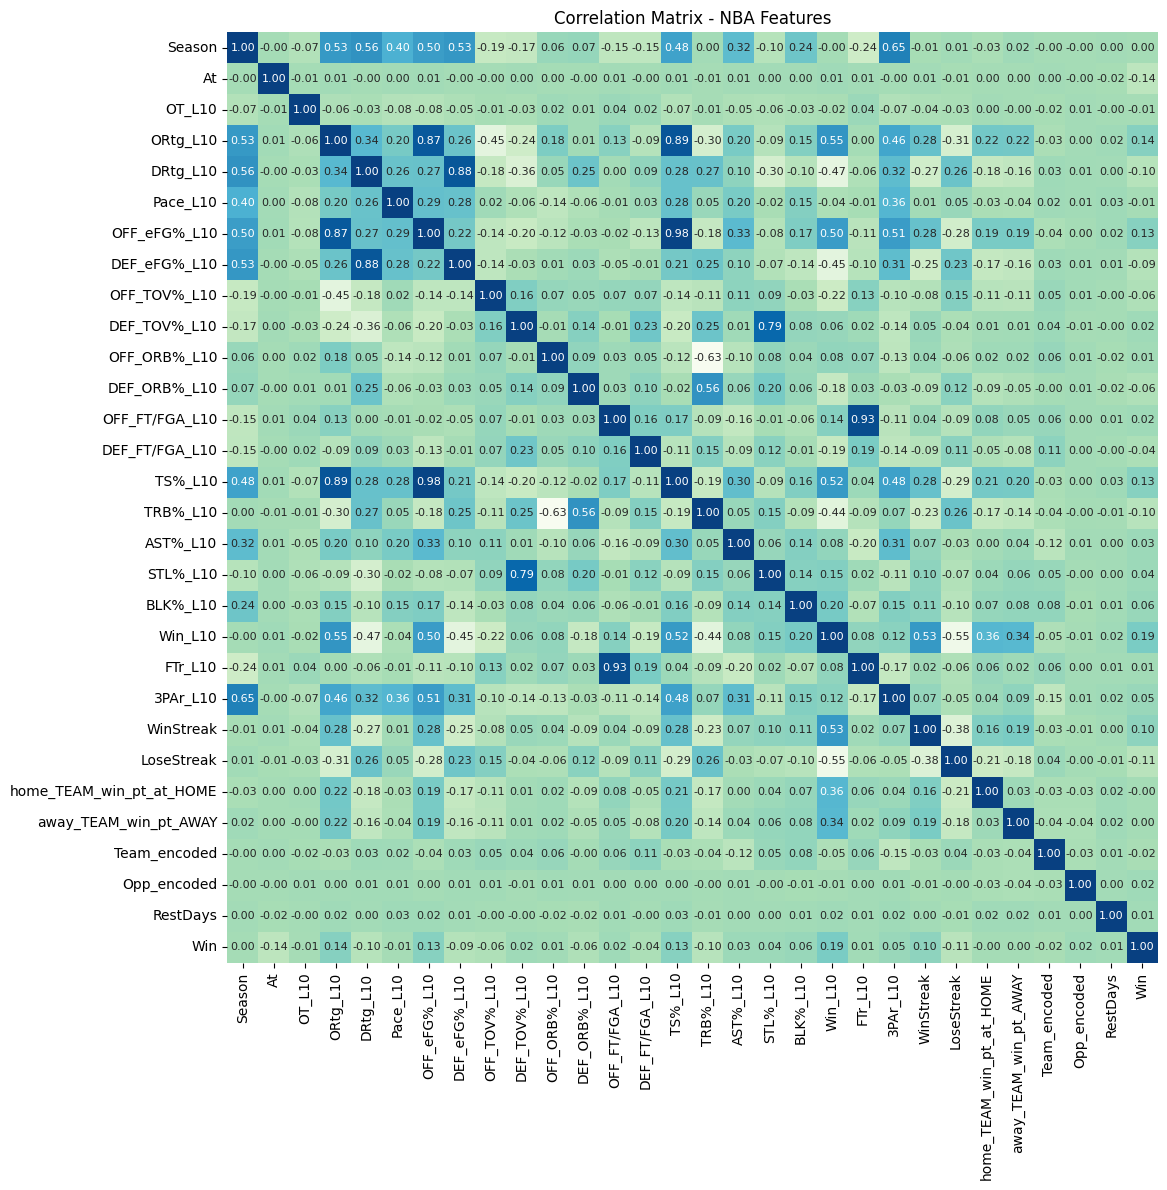

In [27]:
corr_matrix = rolled_df_without_opponent_stats.select_dtypes(include=[np.number]).corr()
cols = rolled_df_without_opponent_stats.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cbar=False, cmap='GnBu', annot_kws={'size': 8}, fmt='.2f', square=True, xticklabels=list(cols), yticklabels=list(cols))
plt.title('Correlation Matrix - NBA Features')
plt.tight_layout()
plt.show()

We already see some things, but we can compute the most correlated with each other

In [28]:
corr_dict = {feat: [0, 'none'] for feat in list(cols)}

list_cols = list(cols)
rows = len(list_cols)
columns = rows

for row in range(rows):
    max_row = 0.0
    for col in list_cols:
        if corr_matrix[col].iloc[row] > max_row and col != list_cols[row]:
            max_row = corr_matrix[col].iloc[row]
            corr_dict[list_cols[row]] = [max_row, col]


corr_dict = dict(sorted(corr_dict.items(), reverse=True ,key=lambda x: x[1]))

#we can now choose a threshold to eliminate strong correlated features, e.g. 0.7
th = 0.7
filtered_out = {}
for k, v in corr_dict.items():
    if v[0] > 0.7:
        if k not in list(filtered_out.values()): #collect each pair only once
            filtered_out[k] = v[1]

print(filtered_out)







{'OFF_eFG%_L10': 'TS%_L10', 'FTr_L10': 'OFF_FT/FGA_L10', 'ORtg_L10': 'TS%_L10', 'DEF_eFG%_L10': 'DRtg_L10', 'DEF_TOV%_L10': 'STL%_L10'}


In [29]:
#now we can mantafilter out from the df in only one feature from each pair (e.g. all the keys)
feature_to_remove = list(filtered_out.keys())
feature_to_mantain = [col for col in list(rolled_df_without_opponent_stats.columns) if col not in feature_to_remove]
print(feature_to_mantain)
print(len(feature_to_mantain))

['Season', 'Date', 'Team', 'At', 'Opp', 'OT_L10', 'DRtg_L10', 'Pace_L10', 'OFF_TOV%_L10', 'OFF_ORB%_L10', 'DEF_ORB%_L10', 'OFF_FT/FGA_L10', 'DEF_FT/FGA_L10', 'TS%_L10', 'TRB%_L10', 'AST%_L10', 'STL%_L10', 'BLK%_L10', 'Win_L10', '3PAr_L10', 'WinStreak', 'LoseStreak', 'home_TEAM_win_pt_at_HOME', 'away_TEAM_win_pt_AWAY', 'Team_encoded', 'Opp_encoded', 'RestDays', 'Win']
28


In [30]:
rolled_df_baseline = rolled_df_without_opponent_stats[feature_to_mantain]
rolled_df_baseline.head()

,Season,Date,Team,At,Opp,OT_L10,DRtg_L10,Pace_L10,OFF_TOV%_L10,OFF_ORB%_L10,...,Win_L10,3PAr_L10,WinStreak,LoseStreak,home_TEAM_win_pt_at_HOME,away_TEAM_win_pt_AWAY,Team_encoded,Opp_encoded,RestDays,Win
10,2015,2014-11-21,ATL,0,DET,0.2,109.08,93.20,14.49,21.95,...,0.5,0.3042,0,2,0.800000,0.166667,0,8,3.0,1
11,2015,2014-11-25,ATL,1,WAS,0.2,107.39,92.79,13.70,21.57,...,0.6,0.3067,1,0,0.833333,0.200000,0,29,4.0,1
12,2015,2014-11-26,ATL,0,TOR,0.2,108.09,93.12,13.34,23.53,...,0.6,0.3071,2,0,0.833333,0.750000,0,27,1.0,0
13,2015,2014-11-28,ATL,0,NOP,0.2,111.80,92.85,13.39,24.14,...,0.6,0.3092,0,1,0.714286,0.428571,0,18,2.0,1
14,2015,2014-11-29,ATL,0,CHO,0.0,111.35,92.29,13.59,25.62,...,0.7,0.2961,1,0,0.750000,0.125000,0,4,1.0,1


we can, additionally, navigate the features with SequentialFeatureSelector and RandomForest FeatureImportance

In [31]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeClassifier

rr = RidgeClassifier(alpha=1)
split=TimeSeriesSplit(n_splits=3)

sfs = SequentialFeatureSelector(rr, n_features_to_select=20, direction='forward', cv=split)

removed_col = ['Season', 'Date', 'Team', 'Opp', 'Win', 'Opp_encoded', 'Team_encoded']
selected_cols = [col for col in list(rolled_df_baseline.columns) if col not in removed_col]

from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler()
rolled_df_baseline[selected_cols] = mm.fit_transform(rolled_df_baseline[selected_cols])


C:\Users\Utente\AppData\Local\Temp\ipykernel_114632\1929107792.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rolled_df_baseline[selected_cols] = mm.fit_transform(rolled_df_baseline[selected_cols])


In [32]:
rolled_df_baseline

,Season,Date,Team,At,Opp,OT_L10,DRtg_L10,Pace_L10,OFF_TOV%_L10,OFF_ORB%_L10,...,Win_L10,3PAr_L10,WinStreak,LoseStreak,home_TEAM_win_pt_at_HOME,away_TEAM_win_pt_AWAY,Team_encoded,Opp_encoded,RestDays,Win
10,2015,2014-11-21,ATL,0.0,DET,0.25,0.473828,0.270090,0.609756,0.440898,...,0.5,0.362265,0.000000,0.071429,0.800000,0.166667,0,8,0.013793,1
11,2015,2014-11-25,ATL,1.0,WAS,0.25,0.431903,0.250594,0.538392,0.425926,...,0.6,0.367431,0.041667,0.000000,0.833333,0.200000,0,29,0.020690,1
12,2015,2014-11-26,ATL,0.0,TOR,0.25,0.449268,0.266286,0.505872,0.503152,...,0.6,0.368258,0.083333,0.000000,0.833333,0.750000,0,27,0.000000,0
13,2015,2014-11-28,ATL,0.0,NOP,0.25,0.541305,0.253447,0.510388,0.527187,...,0.6,0.372598,0.000000,0.035714,0.714286,0.428571,0,18,0.006897,1
14,2015,2014-11-29,ATL,0.0,CHO,0.00,0.530141,0.226819,0.528455,0.585500,...,0.7,0.345526,0.041667,0.000000,0.750000,0.125000,0,4,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28243,2025,2025-04-06,WAS,1.0,BOS,0.00,0.793352,0.573466,0.459801,0.359732,...,0.2,0.631949,0.000000,0.035714,0.657895,0.243243,29,1,0.013793,0
28244,2025,2025-04-08,WAS,1.0,IND,0.00,0.833292,0.506895,0.439928,0.338455,...,0.2,0.640008,0.000000,0.071429,0.710526,0.236842,29,11,0.006897,0
28245,2025,2025-04-09,WAS,0.0,PHI,0.00,0.805011,0.486923,0.429991,0.379827,...,0.2,0.636082,0.000000,0.107143,0.200000,0.275000,29,22,0.000000,0
28246,2025,2025-04-11,WAS,1.0,CHI,0.00,0.806252,0.484546,0.405601,0.394799,...,0.2,0.629882,0.000000,0.142857,0.425000,0.230769,29,3,0.006897,0


In [33]:
sfs.fit(rolled_df_baseline[selected_cols], rolled_df_baseline['Win'])

,estimator,RidgeClassifier(alpha=1)
,n_features_to_select,20
,tol,None
,direction,'forward'
,scoring,None
,cv,TimeSeriesSpl...est_size=None)
,n_jobs,None
,alpha,1
,fit_intercept,True
,copy_X,True
,max_iter,None


In [34]:
predictors = [col for col, selected in zip(selected_cols, sfs.get_support()) if selected]
print([col for col in selected_cols if col not in predictors])

['DEF_ORB%_L10']


We see that SequentialFeatureSelector removed DEF_ORB%_L10, let's see with RandomForest FeatureImportance

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    n_jobs=-1
)

print("Training RandomForest per Feature Importance...")
rf.fit(rolled_df_baseline[selected_cols], rolled_df_baseline['Win'])

feature_importance = pd.DataFrame({
    'feature': selected_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 21 Features più importanti:")
print("="*50)
n = 0
for i, row in feature_importance.head(21).iterrows():
    n+=1
    print(f"{n}. {row['feature']:25} {row['importance']:.4f}")

Training RandomForest per Feature Importance...

Top 21 Features più importanti:
1. home_TEAM_win_pt_at_HOME  0.1263
2. away_TEAM_win_pt_AWAY     0.0983
3. Win_L10                   0.0758
4. At                        0.0738
5. TS%_L10                   0.0708
6. DRtg_L10                  0.0570
7. TRB%_L10                  0.0486
8. OFF_TOV%_L10              0.0458
9. 3PAr_L10                  0.0412
10. DEF_ORB%_L10              0.0398
11. AST%_L10                  0.0386
12. STL%_L10                  0.0385
13. Pace_L10                  0.0380
14. OFF_FT/FGA_L10            0.0379
15. OFF_ORB%_L10              0.0375
16. BLK%_L10                  0.0373
17. DEF_FT/FGA_L10            0.0367
18. LoseStreak                0.0212
19. WinStreak                 0.0169
20. RestDays                  0.0118
21. OT_L10                    0.0083


In [36]:
print(list(rolled_df_baseline.columns))

['Season', 'Date', 'Team', 'At', 'Opp', 'OT_L10', 'DRtg_L10', 'Pace_L10', 'OFF_TOV%_L10', 'OFF_ORB%_L10', 'DEF_ORB%_L10', 'OFF_FT/FGA_L10', 'DEF_FT/FGA_L10', 'TS%_L10', 'TRB%_L10', 'AST%_L10', 'STL%_L10', 'BLK%_L10', 'Win_L10', '3PAr_L10', 'WinStreak', 'LoseStreak', 'home_TEAM_win_pt_at_HOME', 'away_TEAM_win_pt_AWAY', 'Team_encoded', 'Opp_encoded', 'RestDays', 'Win']


we see that DEF_ORB%_L10 is not last, now we check the accuracy with the two models, but first we have to create test and train set

In [37]:
def train_test(data, train_seasons=8):
    seasons = sorted(data['Season'].unique())

    first_excluded = seasons[train_seasons]

    train = data[data['Season'] < first_excluded]
    test = data[data['Season'] >= first_excluded]

    return train, test


# RandomForest

In [38]:

removed_col = ['Date', 'Opp', 'Team']
selected_cols = [col for col in list(rolled_df_baseline.columns) if col not in removed_col]

train_df, test_df = train_test(rolled_df_baseline[selected_cols])

train_target = train_df['Win']
trainset = train_df[[col for col in selected_cols if col != 'Win']]

test_target = test_df['Win']
testset = test_df[[col for col in selected_cols if col != 'Win']]

rf.fit(trainset, train_target)
preds = pd.Series(rf.predict(testset), index=testset.index)

from sklearn.metrics import accuracy_score

print(accuracy_score(test_target, preds))


0.6267908309455588


we see 63%, this is good if we consider that we didn't use XGBoost and we didn't add the opponent infos yet

In [39]:
#try to remove OT_L10

removed_col = ['Date', 'Opp', 'Team', 'OT_L10']
selected_cols = [col for col in list(rolled_df_baseline.columns) if col not in removed_col]

train_df, test_df = train_test(rolled_df_baseline[selected_cols])

train_target = train_df['Win']
trainset = train_df[[col for col in selected_cols if col != 'Win']]

test_target = test_df['Win']
testset = test_df[[col for col in selected_cols if col != 'Win']]

rf.fit(trainset, train_target)
preds = pd.Series(rf.predict(testset), index=testset.index)


print(accuracy_score(test_target, preds)) #!DECREASES

0.6214899713467049


# RidgeClassifier

In [40]:
removed_col = ['Date', 'Opp', 'Team']
selected_cols = [col for col in list(rolled_df_baseline.columns) if col not in removed_col]

train_df, test_df = train_test(rolled_df_baseline[selected_cols])

train_target = train_df['Win']
trainset = train_df[[col for col in selected_cols if col != 'Win']]

test_target = test_df['Win']
testset = test_df[[col for col in selected_cols if col != 'Win']]

rr.fit(trainset, train_target)
preds = pd.Series(rr.predict(testset), index=testset.index)


print(accuracy_score(test_target, preds))

0.6010028653295129


In [41]:
#try to remove DEF_ORB%_L10

removed_col = ['Date', 'Opp', 'Team', 'DEF_ORB%_L10']
selected_cols = [col for col in list(rolled_df_baseline.columns) if col not in removed_col]

train_df, test_df = train_test(rolled_df_baseline[selected_cols])

train_target = train_df['Win']
trainset = train_df[[col for col in selected_cols if col != 'Win']]

test_target = test_df['Win']
testset = test_df[[col for col in selected_cols if col != 'Win']]

rr.fit(trainset, train_target)
preds = pd.Series(rr.predict(testset), index=testset.index)


print(accuracy_score(test_target, preds)) #!ACTUALLY INCREASES!

0.6015759312320917


# Collect Opponent Statistics

In [42]:
def AddOpp(df):
    opp_df = df.copy()
    opp_df = opp_df.drop(columns=['Win','Opp', 'Team', 'At', 'home_TEAM_win_pt_at_HOME' ,'away_TEAM_win_pt_AWAY']) #useless to add

    new_cols = {col: f'Opp_{col}' for col in list(opp_df.columns) if col not in ['Date', 'Season', 'Opp_encoded']}
    opp_df = opp_df.rename(columns={'Team_encoded': 'Opp_encoded', 'Opp_encoded': 'Team_encoded'}) #swithc prospective
    opp_df = opp_df.drop(columns=['Team_encoded']) #useless column (it is our old Opp)
    opp_df = opp_df.rename(columns=new_cols) #rename for bettere understanding after merge



    merged = pd.merge(df, opp_df, on=['Opp_encoded', 'Season', 'Date'], how='left')
    return merged

In [43]:
complete_df = AddOpp(rolled_df_baseline)

complete_df.head()

,Season,Date,Team,At,Opp,OT_L10,DRtg_L10,Pace_L10,OFF_TOV%_L10,OFF_ORB%_L10,...,Opp_TS%_L10,Opp_TRB%_L10,Opp_AST%_L10,Opp_STL%_L10,Opp_BLK%_L10,Opp_Win_L10,Opp_3PAr_L10,Opp_WinStreak,Opp_LoseStreak,Opp_RestDays
0,2015,2014-11-21,ATL,0.0,DET,0.25,0.473828,0.270090,0.609756,0.440898,...,0.190332,0.438892,0.342418,0.264768,0.244259,0.3,0.300062,0.000000,0.107143,0.006897
1,2015,2014-11-25,ATL,1.0,WAS,0.25,0.431903,0.250594,0.538392,0.425926,...,0.325277,0.438290,0.681328,0.584388,0.410578,0.8,0.101881,0.083333,0.000000,0.013793
2,2015,2014-11-26,ATL,0.0,TOR,0.25,0.449268,0.266286,0.505872,0.503152,...,0.529708,0.614088,0.310577,0.593882,0.343076,0.9,0.270510,0.208333,0.000000,0.006897
3,2015,2014-11-28,ATL,0.0,NOP,0.25,0.541305,0.253447,0.510388,0.527187,...,0.491944,0.586394,0.418241,0.500000,0.482255,0.6,0.221327,0.000000,0.035714,0.013793
4,2015,2014-11-29,ATL,0.0,CHO,0.00,0.530141,0.226819,0.528455,0.585500,...,0.195871,0.698977,0.442256,0.164557,0.248434,0.1,0.179996,0.000000,0.285714,0.000000


In [44]:
print(list(complete_df.columns))

['Season', 'Date', 'Team', 'At', 'Opp', 'OT_L10', 'DRtg_L10', 'Pace_L10', 'OFF_TOV%_L10', 'OFF_ORB%_L10', 'DEF_ORB%_L10', 'OFF_FT/FGA_L10', 'DEF_FT/FGA_L10', 'TS%_L10', 'TRB%_L10', 'AST%_L10', 'STL%_L10', 'BLK%_L10', 'Win_L10', '3PAr_L10', 'WinStreak', 'LoseStreak', 'home_TEAM_win_pt_at_HOME', 'away_TEAM_win_pt_AWAY', 'Team_encoded', 'Opp_encoded', 'RestDays', 'Win', 'Opp_OT_L10', 'Opp_DRtg_L10', 'Opp_Pace_L10', 'Opp_OFF_TOV%_L10', 'Opp_OFF_ORB%_L10', 'Opp_DEF_ORB%_L10', 'Opp_OFF_FT/FGA_L10', 'Opp_DEF_FT/FGA_L10', 'Opp_TS%_L10', 'Opp_TRB%_L10', 'Opp_AST%_L10', 'Opp_STL%_L10', 'Opp_BLK%_L10', 'Opp_Win_L10', 'Opp_3PAr_L10', 'Opp_WinStreak', 'Opp_LoseStreak', 'Opp_RestDays']


In [45]:
removed_col = ['Date', 'Opp', 'Team']
selected_cols = [col for col in list(complete_df.columns) if col not in removed_col]

In [46]:
#RANDOM_FOREST
train_df, test_df = train_test(complete_df[selected_cols])

train_target = train_df['Win']
trainset = train_df[[col for col in selected_cols if col != 'Win']]

test_target = test_df['Win']
testset = test_df[[col for col in selected_cols if col != 'Win']]

rf.fit(trainset, train_target)
preds = pd.Series(rf.predict(testset), index=testset.index)

from sklearn.metrics import accuracy_score

print(accuracy_score(test_target, preds))


0.6277936962750716


# Improving Model

In [47]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=200,
        max_depth=5,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        n_jobs=-1
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        n_jobs=-1
    ),
    'CatBoost': CatBoostClassifier(
        iterations=200,
        learning_rate=0.1,
        depth=5,
        random_state=42,
        allow_writing_files=False
    )
}

In [48]:
def evaluateModels(x, y):

    cv = KFold(n_splits=5, shuffle=True, random_state=42)


    results = {}

    for model_name, model in models.items():
        res = cross_val_score(model, x, y, cv=cv, n_jobs=-1, scoring='accuracy')
        results[model_name] = {'mean': res.mean(), 'std': res.std()}
        print(f'MODEL: {model_name}: {results[model_name]['mean']}')
    
    plt.figure(figsize=(15, 9))
    plt.bar(list(results.keys()), list(map( lambda x: x['mean'], list(results.values()))), yerr= list(map(lambda x: x['std'], list(results.values()))), capsize=5, alpha=0.7)
    plt.title('Accuracy On NBA Predicttion')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [49]:
train_df, test_df = train_test(complete_df[selected_cols])

train_target = train_df['Win']
trainset = train_df[[col for col in selected_cols if col != 'Win']]

test_target = test_df['Win']
testset = test_df[[col for col in selected_cols if col != 'Win']]

MODEL: RandomForest: 0.6381904869435576
MODEL: XGBoost: 0.6392480989669365
MODEL: LightGBM: 0.6356302468427371
MODEL: CatBoost: 0.6447022056893227


C:\Users\Utente\AppData\Local\Temp\ipykernel_114632\858737962.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


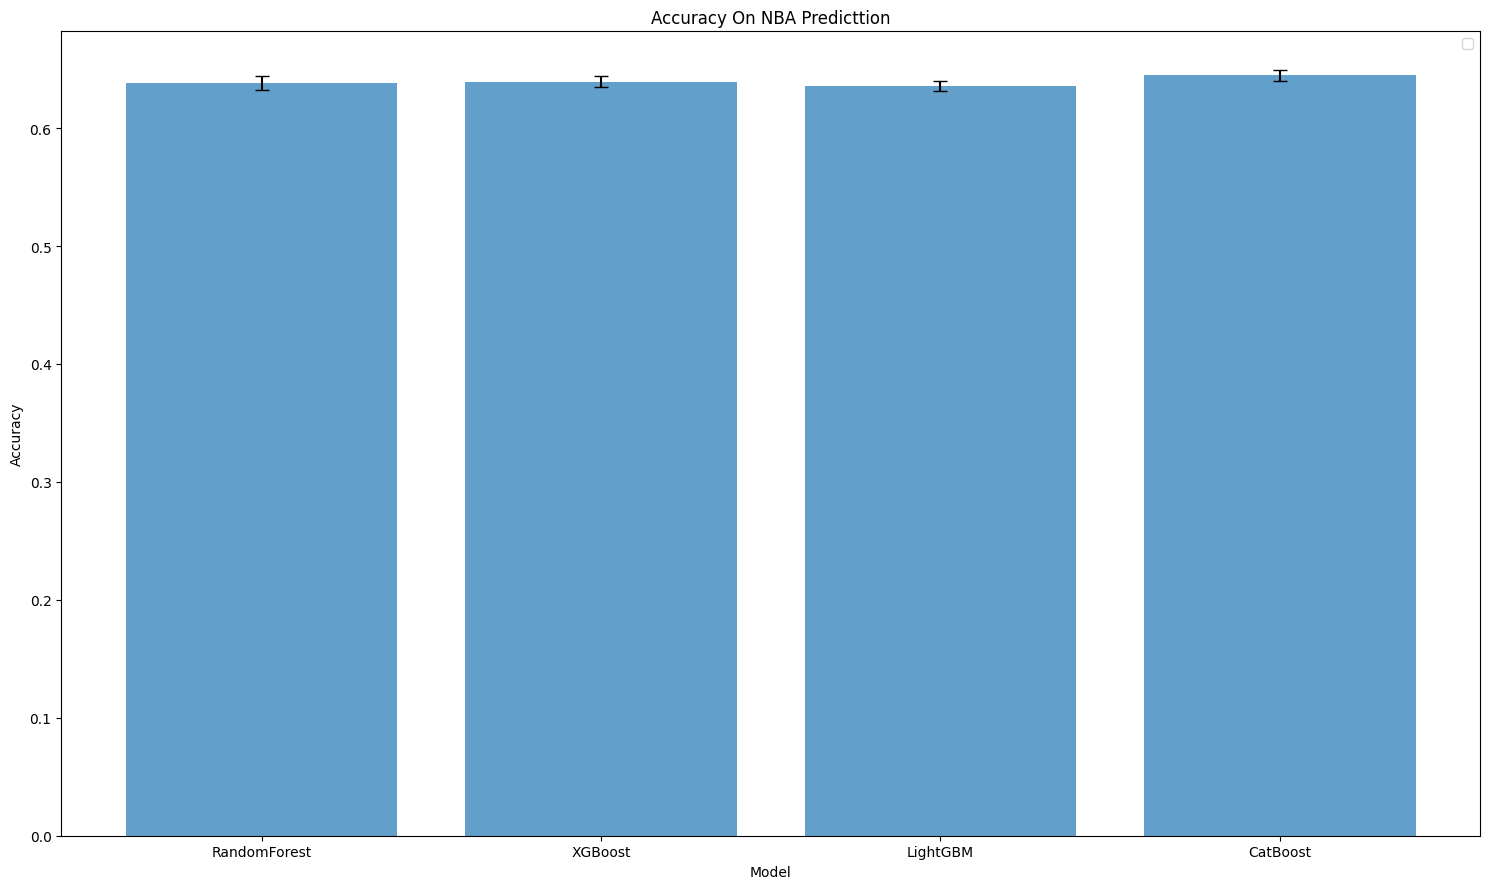

In [50]:
evaluateModels(trainset, train_target)

# Hyperparameters Tuning

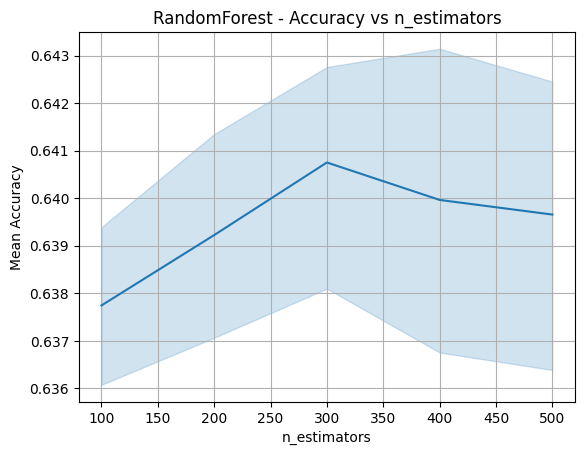

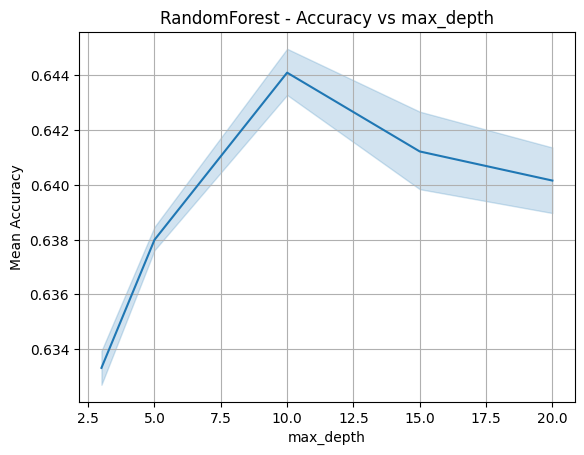

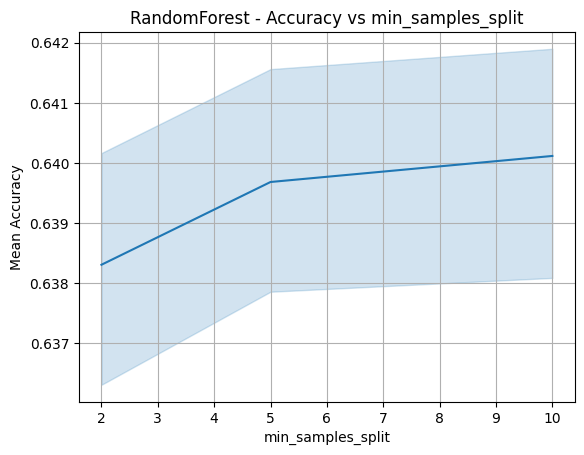

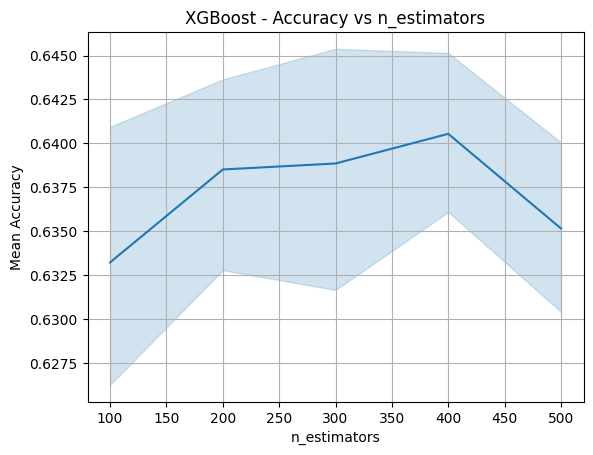

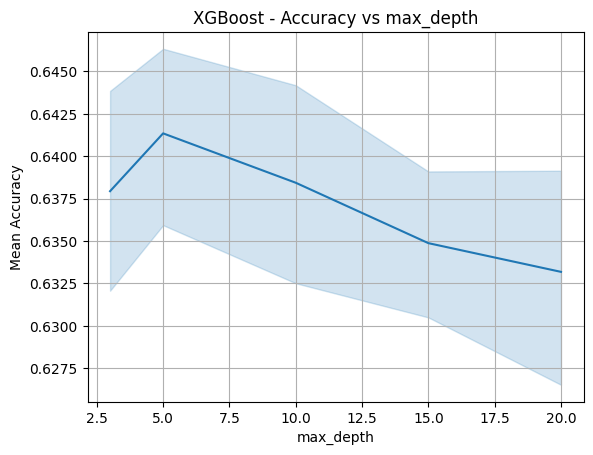

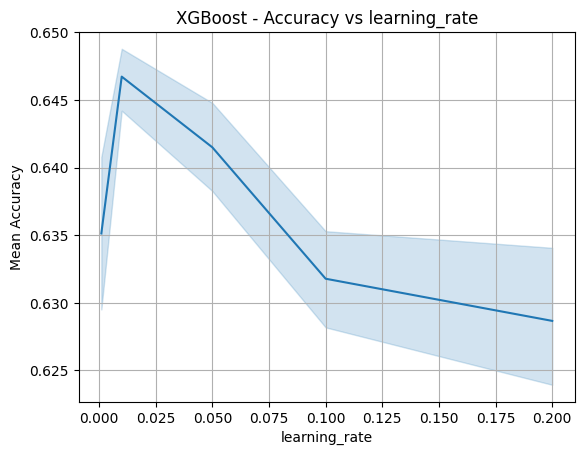

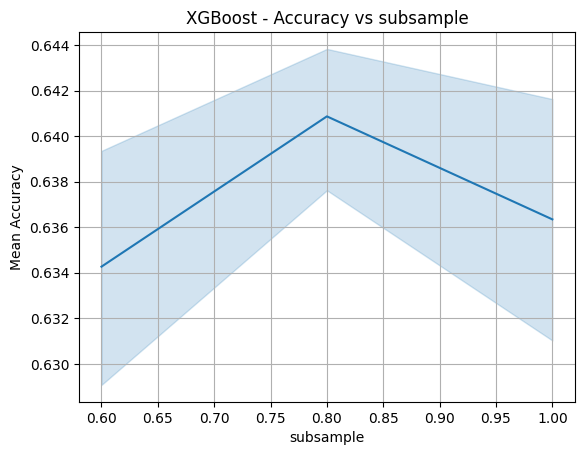

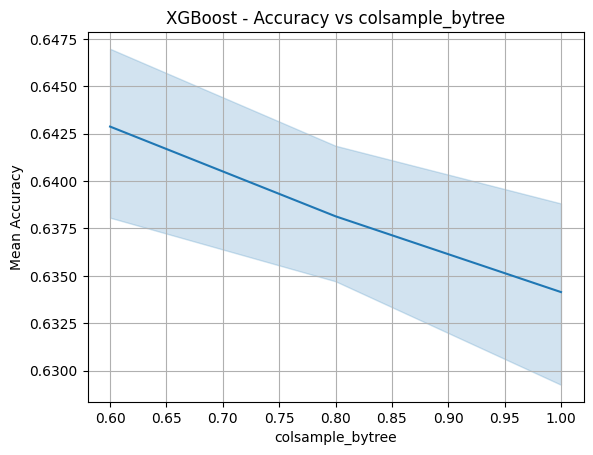

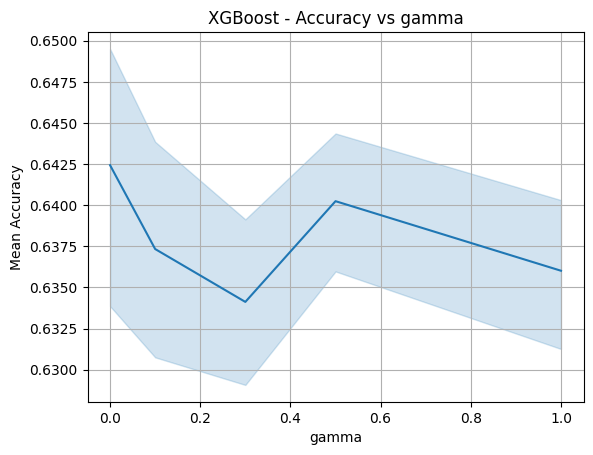

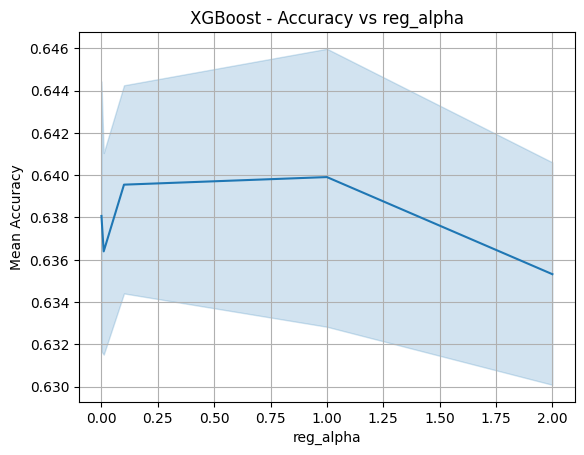

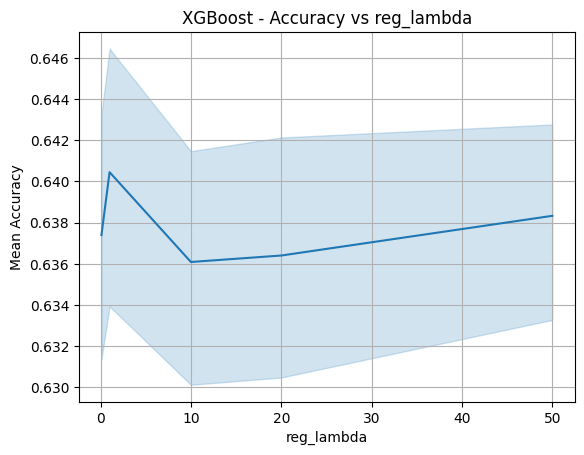

[LightGBM] [Info] Number of positive: 8981, number of negative: 8987
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7366
[LightGBM] [Info] Number of data points in the train set: 17968, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499833 -> initscore=-0.000668
[LightGBM] [Info] Start training from score -0.000668


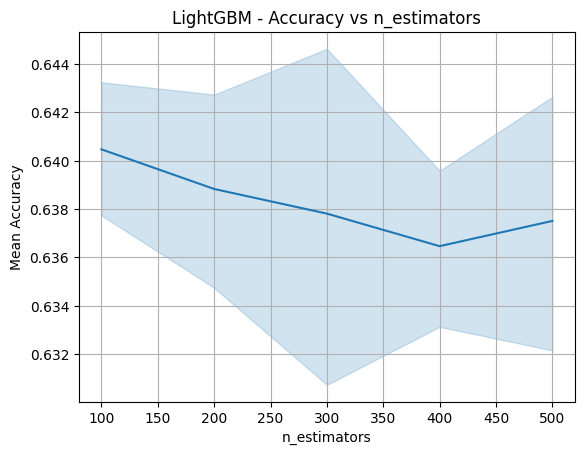

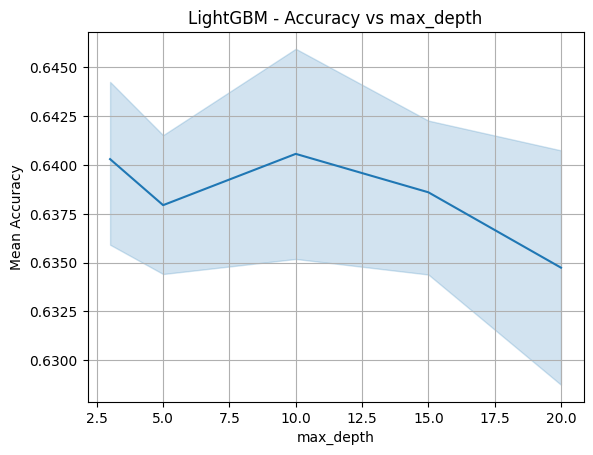

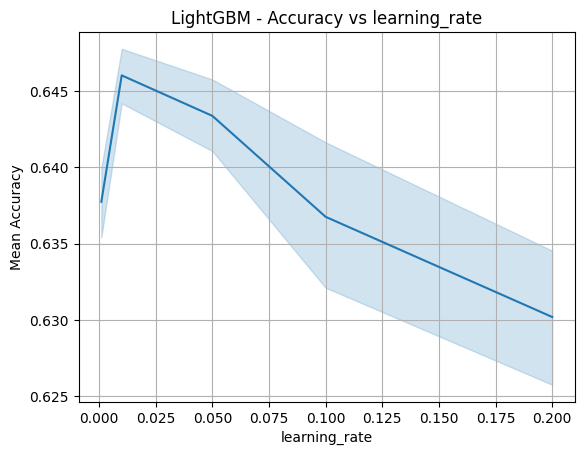

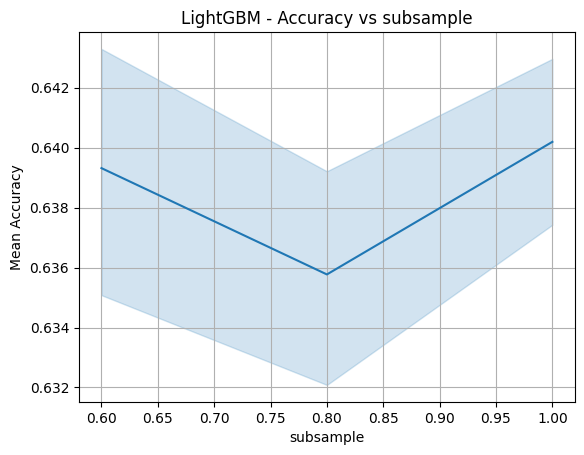

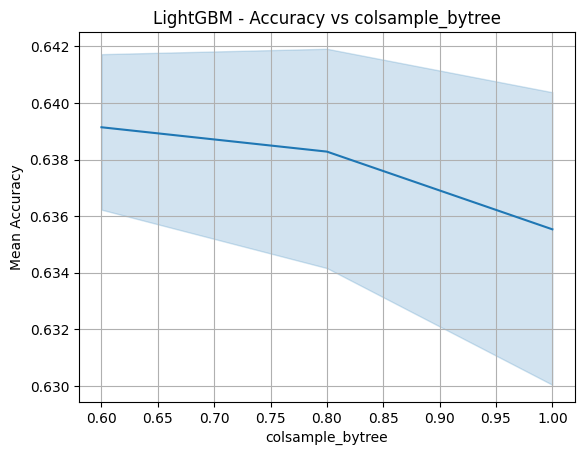

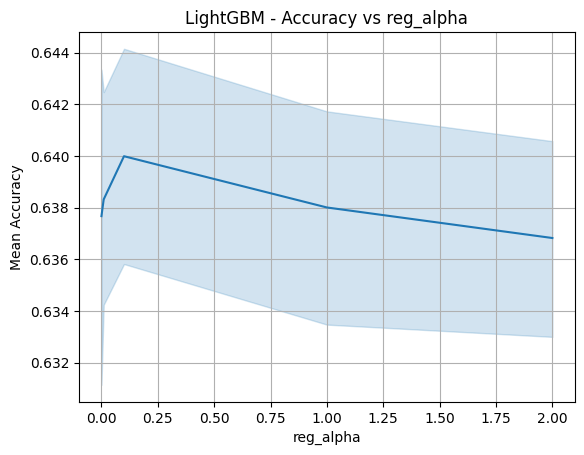

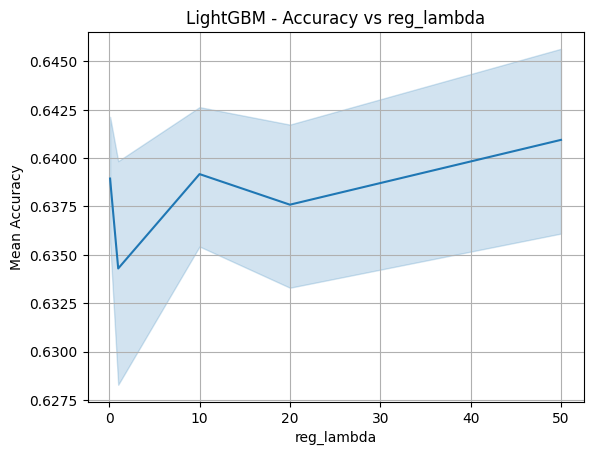

c:\Users\Utente\Politecnico Di Torino Studenti Dropbox\Luigi Gonnella\PersonalStudy\projects\NBA-Predictor\venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Utente\Politecnico Di Torino Studenti Dropbox\Luigi Gonnella\PersonalStudy\projects\NBA-Predictor\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Utente\Politecnico Di Torino Studenti Dropbox\Luigi Gonnella\PersonalStudy\projects\NBA-Predictor\venv\Lib\site-packag

0:	learn: 0.6893083	total: 142ms	remaining: 28.3s
1:	learn: 0.6857872	total: 145ms	remaining: 14.3s
2:	learn: 0.6825497	total: 147ms	remaining: 9.67s
3:	learn: 0.6796715	total: 149ms	remaining: 7.32s
4:	learn: 0.6769235	total: 151ms	remaining: 5.91s
5:	learn: 0.6749642	total: 154ms	remaining: 4.97s
6:	learn: 0.6728021	total: 156ms	remaining: 4.29s
7:	learn: 0.6705882	total: 158ms	remaining: 3.79s
8:	learn: 0.6681954	total: 160ms	remaining: 3.4s
9:	learn: 0.6665711	total: 162ms	remaining: 3.08s
10:	learn: 0.6653628	total: 164ms	remaining: 2.83s
11:	learn: 0.6637299	total: 167ms	remaining: 2.62s
12:	learn: 0.6622789	total: 170ms	remaining: 2.44s
13:	learn: 0.6611805	total: 172ms	remaining: 2.29s
14:	learn: 0.6598035	total: 174ms	remaining: 2.15s
15:	learn: 0.6585817	total: 177ms	remaining: 2.03s
16:	learn: 0.6576649	total: 179ms	remaining: 1.92s
17:	learn: 0.6565778	total: 181ms	remaining: 1.83s
18:	learn: 0.6557459	total: 183ms	remaining: 1.74s
19:	learn: 0.6548086	total: 185ms	remainin

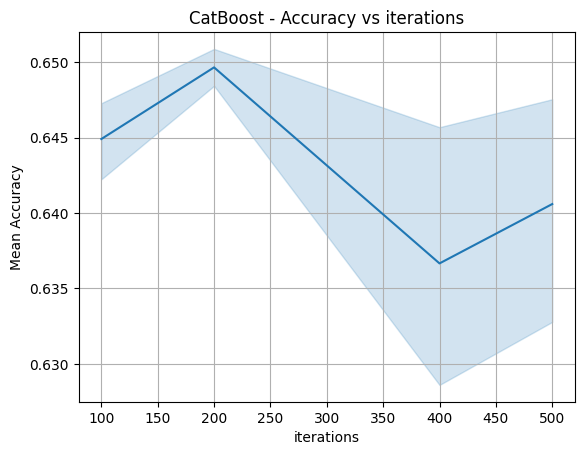

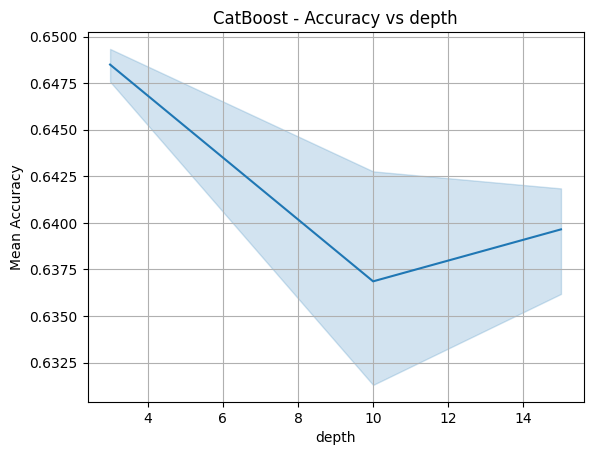

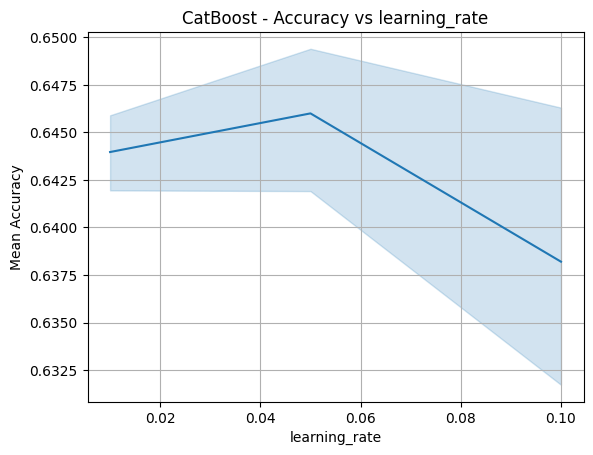

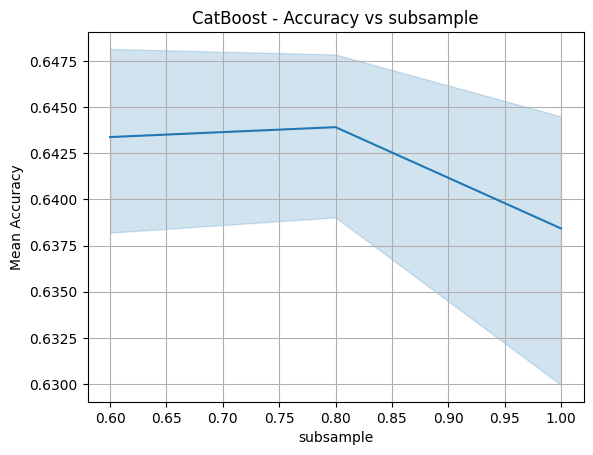

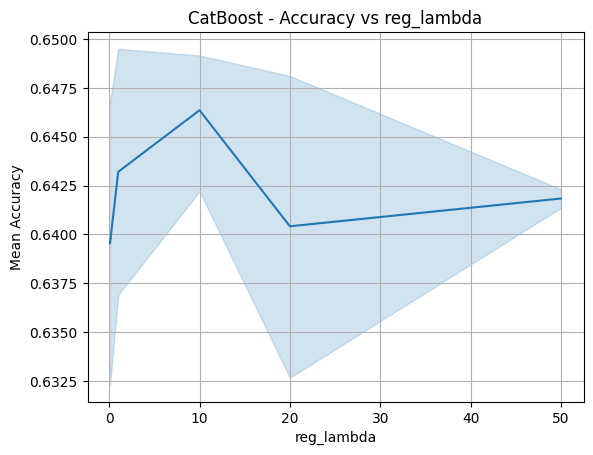

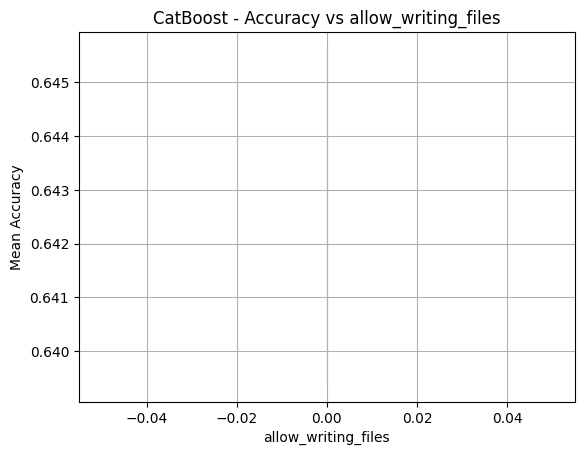

In [51]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'XGBoost': {
        'n_estimators': [100, 200, 300, 400, 500], 
        'max_depth': [3, 5, 10,15,20], 
        'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0], 
        'colsample_bytree': [0.6, 0.8, 1.0], 
        'gamma': [0, 0.1, 0.3, 0.5, 1],
        'reg_alpha': [0, 0.01, 0.1, 1, 2], 
        'reg_lambda': [0.1, 1, 10, 20, 50] 
    },
    'CatBoost': {
        'iterations': [100, 200, 400, 500], 
        'depth': [3, 10, 15, 20], 
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8, 1.0], 
        'reg_lambda': [0.1, 1, 10, 20, 50],
        'allow_writing_files': [False]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300, 400, 500], 
        'max_depth': [3, 5, 10,15,20], 
        'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0], 
        'colsample_bytree': [0.6, 0.8, 1.0], 
        'reg_alpha': [0, 0.01, 0.1, 1, 2], 
        'reg_lambda': [0.1, 1, 10, 20, 50] 
    },
    'RandomForest': {
        'n_estimators': [100, 200, 300, 400, 500], 
        'max_depth': [3, 5, 10, 15, 20, None],
        "min_samples_split": [2, 5, 10]
    }
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
gs = {}

for model_name, model in models.items():

    params = param_grid[model_name]
    if model_name != 'CatBoost':
        gs[model_name] = RandomizedSearchCV(model, params, scoring='accuracy', n_jobs=-1, cv=cv, return_train_score=True, n_iter=50)
    else:
        gs[model_name] = RandomizedSearchCV(model, params, scoring='accuracy', n_jobs=-1, cv=cv, return_train_score=True, n_iter=30)

    gs[model_name].fit(trainset, train_target)

    for param in params.keys():

        mean_scores = pd.DataFrame(gs[model_name].cv_results_) #conerts dictionary into df
        #this pd will have a columns for each tested param (from the grid of that model) with the corresponding mean accuracy (across all folds) with the configuration of the row, for each row
        # -->  param_C	 param_max_depth	    mean_test_score	
                #0.01	    3	                0.65	
                #0.1	    5	                0.72	
                #1	        10	                0.78	
                #10	        None	            0.75	
                #100	    None	            0.70	
        mean_scores = mean_scores[['param_' + param, 'mean_test_score']] #takes only 2 columns
        plt.figure()
        sns.lineplot(x=mean_scores['param_' + param], y=mean_scores['mean_test_score'])
        plt.title(f'{model_name} - Accuracy vs {param}')
        plt.xlabel(param)
        plt.ylabel('Mean Accuracy')
        plt.grid(True)
        plt.show()





Evaluating RandomForest...
Best parameters for RandomForest: {'n_estimators': 400, 'min_samples_split': 5, 'max_depth': 10}


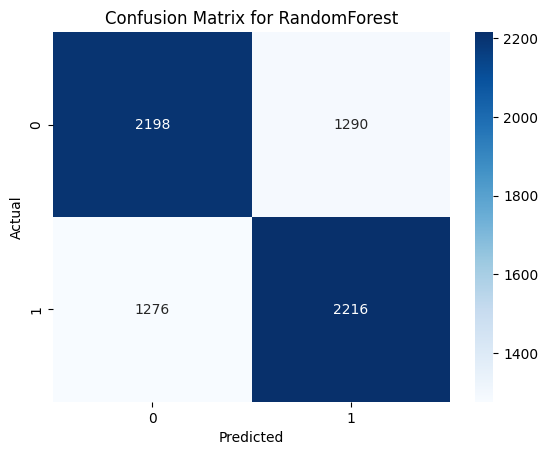

Evaluating XGBoost...
Best parameters for XGBoost: {'subsample': 0.8, 'reg_lambda': 10, 'reg_alpha': 1, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}


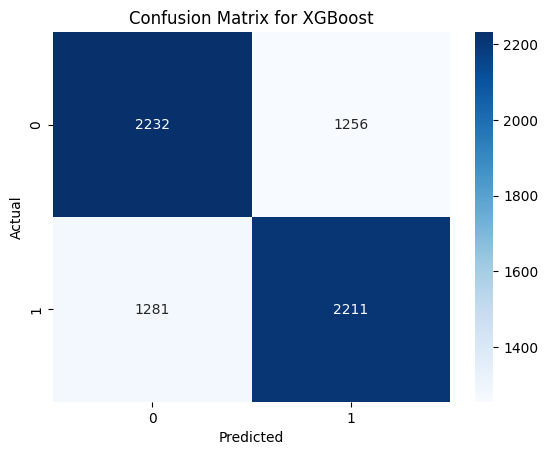

Evaluating LightGBM...
Best parameters for LightGBM: {'subsample': 0.6, 'reg_lambda': 50, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


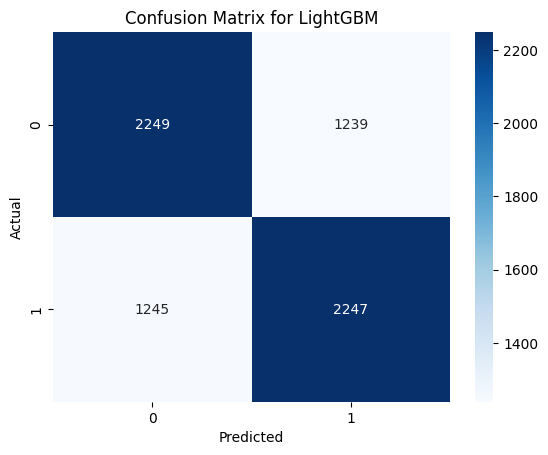

Evaluating CatBoost...
Best parameters for CatBoost: {'subsample': 0.6, 'reg_lambda': 10, 'learning_rate': 0.05, 'iterations': 200, 'depth': 3, 'allow_writing_files': False}


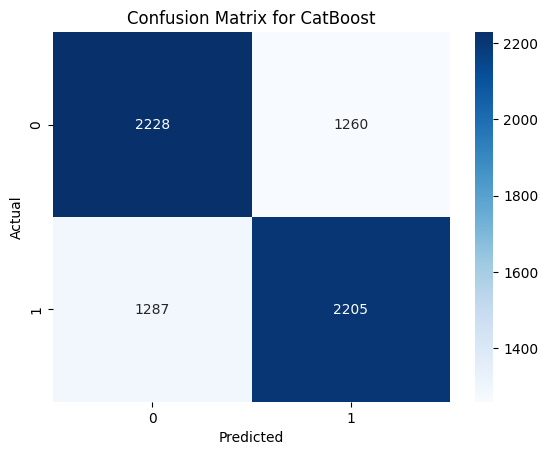

1): LightGBM --> BEST MODEL ✅
PARAMETERS: LGBMClassifier(colsample_bytree=0.8, learning_rate=0.01, max_depth=10,
               n_estimators=300, n_jobs=-1, random_state=42, reg_alpha=0.1,
               reg_lambda=50, subsample=0.6)
ACCURACY: 0.6441260744985673
2): XGBoost
PARAMETERS: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              

In [63]:
best_models = {}
for name, model in models.items():
    print(f"Evaluating {name}...")
    y_pred = gs[name].best_estimator_.predict(testset)
    best_models[name] = {}
    best_models[name]['best_estimator'] = gs[name].best_estimator_

    y_pred = pd.Series(y_pred, index=testset.index)
    accuracy = accuracy_score(test_target, y_pred)
    best_models[name]['Accuracy'] = accuracy


    print(f"Best parameters for {name}: {gs[name].best_params_}")
    sns.heatmap(pd.crosstab(test_target, y_pred, rownames=['Actual'], colnames=['Predicted']), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

best_models_sorted = sorted(best_models.items(), key=lambda x: x[1]['Accuracy'], reverse=True)

f = 1
for i, el in enumerate(best_models_sorted):
    if f==1:
        f=0
        print(f'1): {el[0]} --> BEST MODEL ✅')
        print(f'PARAMETERS: {el[1]['best_estimator']}')
        print(f'ACCURACY: {el[1]['Accuracy']}')
    else:
        print(f'{i+1}): {el[0]}')
        print(f'PARAMETERS: {el[1]['best_estimator']}')
        print(f'ACCURACY: {el[1]['Accuracy']}')



# Save model 

In [64]:
import joblib
import json
from datetime import datetime

model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

joblib.dump(best_models_sorted[0][1]['best_estimator'], model_dir / 'best_model.pkl')

# 2. Salva i parametri
params_dict = {
    'model': best_models_sorted[0][0],
    'accuracy': float(best_models_sorted[0][1]['Accuracy']),
    'best_params': gs[best_models_sorted[0][0]].best_params_,
    'training_date': datetime.now().isoformat(),
    'features': list(trainset.columns)
}

with open(model_dir / 'model_info.json', 'w') as f:
    json.dump(params_dict, f, indent=4)